In [ ]:
# Notebook cell 1: setup (run in a cell with !)
!pip install -q numpy pandas scikit-learn matplotlib seaborn
!pip install -q tensorflow   # or latest TF2.x
!pip install -q transformers datasets torch
!pip install -q imbalanced-learn    # for SMOTE if needed

In [ ]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [ ]:
!gdown 1R5vJGZveHFkNjEcNWef39MF4R2tQeM9S -O ISOT_FakeNews.zip
!unzip -q ISOT_FakeNews.zip


Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1R5vJGZveHFkNjEcNWef39MF4R2tQeM9S

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open ISOT_FakeNews.zip, ISOT_FakeNews.zip.zip or ISOT_FakeNews.zip.ZIP.


In [ ]:
import os
import pandas as pd

fake_path = "Fake"
true_path = "True"

data = []

# Load fake articles
for file in os.listdir(fake_path):
    with open(os.path.join(fake_path, file), "r", encoding="latin-1") as f:
        text = f.read()
        data.append([text, "fake"])

# Load real articles
for file in os.listdir(true_path):
    with open(os.path.join(true_path, file), "r", encoding="latin-1") as f:
        text = f.read()
        data.append([text, "real"])

df = pd.DataFrame(data, columns=["text", "label"])
df.to_csv("ISOT_FakeNews.csv", index=False)

df.head(), df.shape


FileNotFoundError: [Errno 2] No such file or directory: 'Fake'

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


KeyboardInterrupt: 

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload the zip from your computer
!unzip -q your_downloaded_file.zip


Saving archive.zip to archive.zip
unzip:  cannot find or open your_downloaded_file.zip, your_downloaded_file.zip.zip or your_downloaded_file.zip.ZIP.


In [ ]:
!unzip -q archive.zip


In [ ]:
!ls


archive.zip  Fake.csv  sample_data  True.csv


In [ ]:
import pandas as pd

df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

df_fake["label"] = "fake"
df_real["label"] = "real"

df = pd.concat([df_fake, df_real], ignore_index=True)
df = df[["text", "label"]]

df.head(), df.shape


(                                                text label
 0  Donald Trump just couldn t wish all Americans ...  fake
 1  House Intelligence Committee Chairman Devin Nu...  fake
 2  On Friday, it was revealed that former Milwauk...  fake
 3  On Christmas day, Donald Trump announced that ...  fake
 4  Pope Francis used his annual Christmas Day mes...  fake,
 (44898, 2))

In [ ]:
import re

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", " ", text)      # keep only letters
    text = re.sub(r"\s+", " ", text)             # remove extra spaces
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

df.head()


,text,label,clean_text
0,Donald Trump just couldn t wish all Americans ...,fake,donald trump just couldn t wish all americans ...
1,House Intelligence Committee Chairman Devin Nu...,fake,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",fake,on friday it was revealed that former milwauke...
3,"On Christmas day, Donald Trump announced that ...",fake,on christmas day donald trump announced that h...
4,Pope Francis used his annual Christmas Day mes...,fake,pope francis used his annual christmas day mes...


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

X = df["clean_text"]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((35918,), (8980,))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 50000       # keep top 50k words
MAX_LEN = 300           # max length of each text

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

X_train_pad.shape, X_test_pad.shape


((35918, 300), (8980, 300))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=4,
    batch_size=64
)


Epoch 1/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 358s 797ms/step - accuracy: 0.9089 - loss: 0.2213 - val_accuracy: 0.9617 - val_loss: 0.1451
Epoch 2/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 386s 805ms/step - accuracy: 0.8855 - loss: 0.2326 - val_accuracy: 0.9847 - val_loss: 0.0632
Epoch 3/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 361s 759ms/step - accuracy: 0.9931 - loss: 0.0290 - val_accuracy: 0.9866 - val_loss: 0.0549
Epoch 4/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 361s 804ms/step - accuracy: 0.9987 - loss: 0.0073 - val_accuracy: 0.9858 - val_loss: 0.0609


In [ ]:
loss, acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", acc)


281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.9861 - loss: 0.0547
Test Accuracy: 0.9879732728004456


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
from tensorflow.keras.models import load_model
import pickle

# load saved model
model = load_model("lstm_fakenews_model.h5")

# load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'lstm_fakenews_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
model.save("lstm_fakenews_model.h5")
print("model saved!")


model saved!


In [ ]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("tokenizer saved!")


tokenizer saved!


In [ ]:
!ls


archive.zip  lstm_fakenews_model.h5  tokenizer.pkl
Fake.csv     sample_data	     True.csv


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# load saved model
model = load_model("lstm_fakenews_model.h5")

# load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

MAX_LEN = 300

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def predict_news(text):
    cleaned = clean_text(text)

    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding="post")

    prob = model.predict(pad)[0][0]

    label = "REAL" if prob < 0.5 else "FAKE"

    return label, float(prob)


In [ ]:
text = input("Enter news text: ")
label, confidence = predict_news(text)

print("Prediction:", label)
print("Confidence:", confidence)


Enter news text: WHATT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Prediction: REAL
Confidence: 0.0002301535860169679


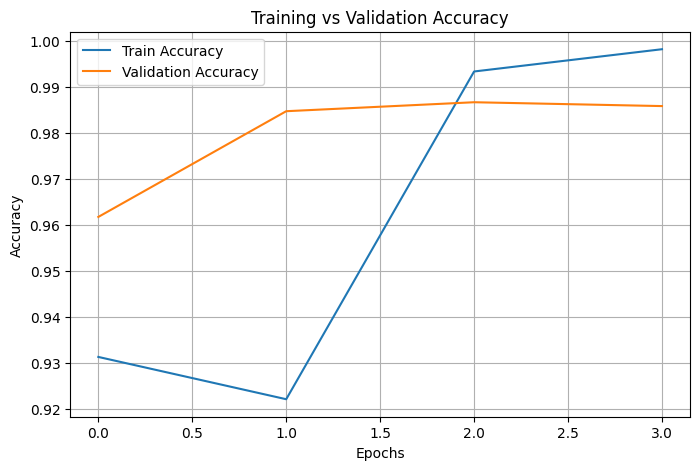

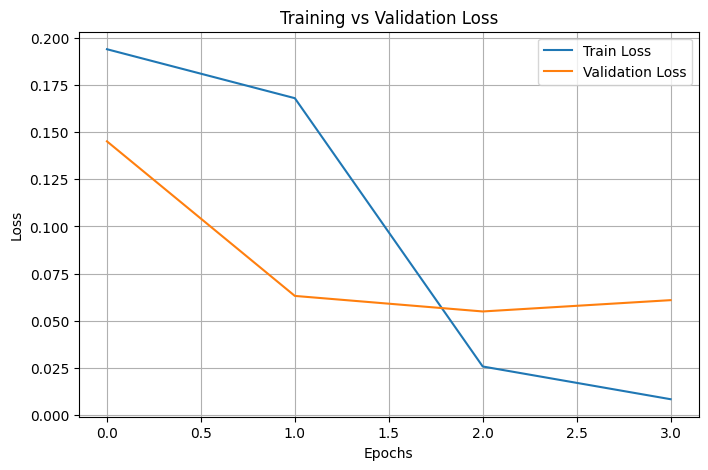

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


281/281 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step


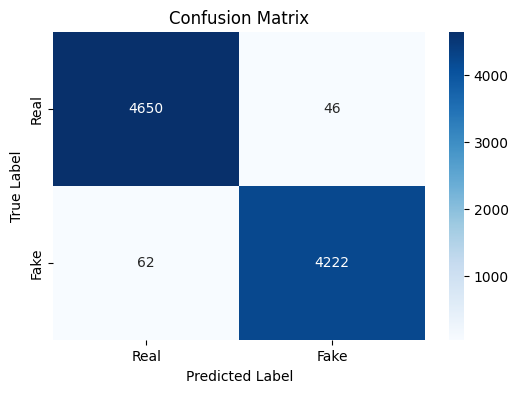

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# generate predictions
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
